# 실습 프로세스


사용 데이터
1. Melbourne 기온 데이터 (ts1)
    - Daily Minimum Temperatures in Melbourne (1981~1990)

2. 항공 승객 수 데이터 (ts2)
    - International Airline Passengers (1949~1960)

```
📂 1. 데이터 로드 및 시계열 구조화
│
├── ts1: 멜버른 기온 데이터
│     - CSV → datetime 인덱스
│     - 컬럼명: 'Temp'
│     - Series(ts1)로 추출
│
└── ts2: 국제 항공 승객 수 데이터
      - CSV → datetime 인덱스
      - 컬럼명: 'Passengers'
      - Series(ts2)로 추출


📂 2. 결측치 및 이상치 처리
│
├── ts1
│   └── '?0.2' 등 비정상값 → NaN → dropna()
│
└── ts2
    └── 결측 없음 → 그대로 사용


📂 3. 정성적 정상성 분석 (시각화)
│
├── plot_rolling_statistics(ts1)
│   └── Rolling Mean·Std 일정 → 정상성
│
└── plot_rolling_statistics(ts2)
    └── 추세와 분산 증가 → 비정상성 추정


📂 4. 정량적 정상성 분석 (ADF Test)
│
├── augmented_dickey_fuller_test(ts1)
│   └── p ≈ 0 → 정상성
│
└── augmented_dickey_fuller_test(ts2)
    └── p ≈ 1 → 비정상성


📂 5. 비정상 시계열(ts2) 변환 → 정상화
│
├── 로그 변환
│   └── ts_log = np.log(ts2)
│   └── augmented_dickey_fuller_test(ts2)
│       └── p ≈ 0.42 → 비정상성
│
├── 이동 평균 제거
│   └── moving_avg = ts_log.rolling(12).mean()
│   └── ts_log_moving_avg = ts_log - moving_av
│   └── ts_log_moving_avg.dropna()
│
├── ADF Test
│   └── plot_rolling_statistics(ts_log_moving_avg)
│   └── augmented_dickey_fuller_test(ts_log_moving_avg)
│       → p ≈ 0.02 → 거의 정상
│       → 추세 제거 시 window 크기 선택이 중요
│
└── 차분 수행
│   └── ts_log_moving_avg - ts_log_moving_avg.shift(-1)
│   └── dropna() 후 ADF Test
│       → p ≈ 0.0019 → 완전한 정상성 확보
│
└──  각 과정이 지니는 의미 이해


📂 6. 시계열 분해 (Decomposition)
│
├── decomposition = seasonal_decompose(ts_log)
│   ├── original
│   ├── trend
│   ├── seasonal
│   └── residual (✔ 분석 대상)
│
├── plot_rolling_statistics(residual)
├── augmented_dickey_fuller_test(residual)
│   └── p ≈ 0.000 → 매우 안정적인 정상 시계열
└──  ✔ residual을 기반으로 모델링 가능


📂 7. ACF / PACF 분석 → ARIMA 파라미터 추정
│
├── plot_acf(ts_log) → q 추정
│     ↳ 완만한 감소 → q = 0~1
│
├── plot_pacf(ts_log) → p 추정
│     ↳ lag 1, lag 14 → p = 1 또는 14
│
└── 차분 횟수(d) 추정
    ├── diff_1 = ts_log.diff(1) → p ≈ 0.07
    ├── diff_2 = diff_1.diff(1) → p ≈ 0
    └── d = 1 또는 2 시도 가능


📂 8. ARIMA 모델 훈련 및 예측
│
├── 데이터 분할
│   ├── train_data = ts_log[:90%]
│   └── test_data = ts_log[90%:]
│
├── 모델 학습
│   └── model = ARIMA(train_data, order=(14, 1, 0))
│   └── fitted_m = model.fit()
│
├── 훈련 예측 시각화
│   └── predict()  vs train_data
│
└── 테스트 예측
    ├── forecast(len(test_data), alpha=0.05) → fc
    ├── fc_series = pd.Series(fc, index=test_data.index)
    └── 시각화로 actual vs predicted 비교


📂 9. 예측 성능 평가
│
├── np.exp(test_data), np.exp(fc) → 원래 단위 복원
│
├── 평가 지표 계산
│   ├── MSE, MAE, RMSE
│   └── MAPE = 2.62%
│
└── 비교적 높은 정확도 / 모델 성능 양호
```

<br>

# 9-4. 시계열 데이터 사례 분석

첫 번째로 다루어볼 데이터는 Daily Minimum Temperatures in Melbourne이다.

온도 변화를 다루는 시계열인 만큼 안정성이 있지 않을까 예상할 수 있다.

### 시계열(Time Series) 생성

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

In [62]:
import pandas as pd

raw_url = "https://raw.githubusercontent.com/upul/WhiteBoard/master/data/daily-minimum-temperatures-in-me.csv"

# CSV 읽기
df = pd.read_csv(
    raw_url,
    quotechar='"',
    on_bad_lines='skip',
    parse_dates=['Date'],  # 날짜를 datetime 형식으로 자동 변환
    index_col='Date'  # 날짜 컬럼을 인덱스로 사용
)
df.rename(columns={
    'Daily minimum temperatures in Melbourne, Australia, 1981-1990': 'Temp'
}, inplace=True)

print(type(df))
df.head()
# print(df.columns)

<class 'pandas.core.frame.DataFrame'>


,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


시계열(Time Series)은 결국 시간 컬럼을 index로 하는 Series로 표현된다.

위에서 읽어 들인 데이터 파일은 Pandas를 통해 2개의 컬럼을 가진 DataFrame으로 변환되었다. 이것은 아직 시계열의 데이터 구조는 아니다.

시간 컬럼이 index가 되었지만 아직도 type은 DataFrame으로 나오기 때문에 이를 Series로 변환시킨다.

In [63]:
ts1 = df['Temp']  # 우선은 데이터 확인용이니 time series 의 이니셜을 따서 'ts'라고 이름 붙여준다.
print(type(ts1))
ts1.head()

<class 'pandas.core.series.Series'>


,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


DataFrame인 df와 Series인 df['Temp']는 index 구조가 동일하므로 Numpy, Pandas, Matplotlib 등 많은 라이브러리들이 호환해서 지원해 준다. 하지만 그렇지 않은 경우도 간혹 발생하므로 여기서는 명확하게 Series 객체를 가지고 진행하도록 하겠다.

<br>

### 시계열 정상성의 정성적 분석

이제 시계열이 준비되었으므로 시각화를 통해 정상성(Stationarity) 여부를 확인해 본다.

In [64]:
# ?0.2 같은 잘못된 값이 섞여 있음 → errors='coerce' 옵션으로 자동 NaN 처리
ts1 = pd.to_numeric(ts1, errors='coerce')  # 오류 값은 NaN 처리
print(ts1.dtypes)  # float64일 것

# NaN 있는지 확인
print("결측치 개수:", ts1.isna().sum())

# 결측치 개수 확인 후 제거
ts1 = ts1.dropna()

# NaN 있는지 확인
print("결측치 개수:", ts1.isna().sum())

float64
결측치 개수: 3
결측치 개수: 0


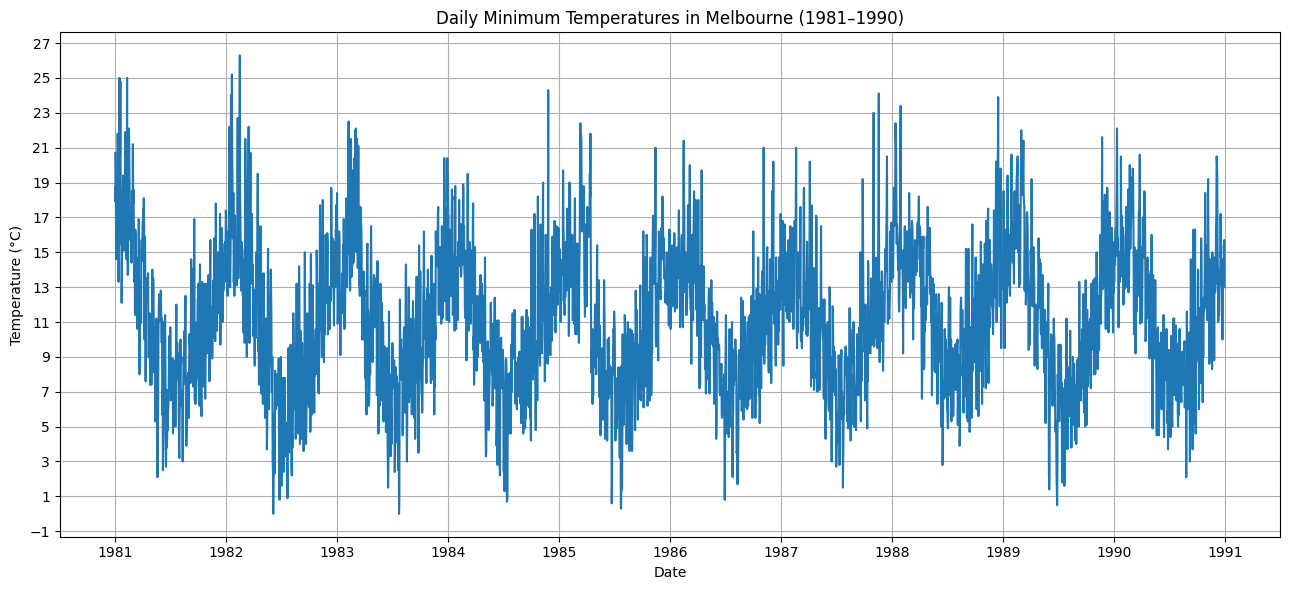

In [65]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams['figure.figsize'] = (13, 6)

plt.plot(ts1)

# y축 틱을 적당히 정리 (예: 최소~최대 구간을 2 간격으로 표시)
# y축 눈금을 보기 좋게 2 간격으로 설정
yticks = np.arange(int(ts1.min()) - 1, int(ts1.max()) + 2, 2)
plt.yticks(yticks)

plt.title("Daily Minimum Temperatures in Melbourne (1981–1990)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

분석에 들어가기 전에 결측치 유무 한 번 더 확인한다.


In [66]:
ts1[ts1.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

,Temp
Date,


만약 결측치가 있다면 조치가 필요하다. NaN이 들어있는 데이터는 통계분석 시에 많은 오류를 일으킬뿐더러 분석 결과에도 악영향을 미칠 것이다.

만약 결측치가 있다면, 두 가지 방법으로 결측치를 처리해 줄 수 있다.

1. 결측치가 있는 데이터를 모두 삭제(drop)

2. 결측치 양옆의 값들을 이용해서 적절히 보간(interpolate)하여 대입  
    ex) 2와 4 사이 데이터가 NaN이라면 이 값을 3으로 채우는 방식

이번 경우라면 시간을 index로 가지는 시계열 데이터이므로 삭제하는 것보다는 보간하는 방법을 선택하겠다.

Series([], Name: Temp, dtype: float64)


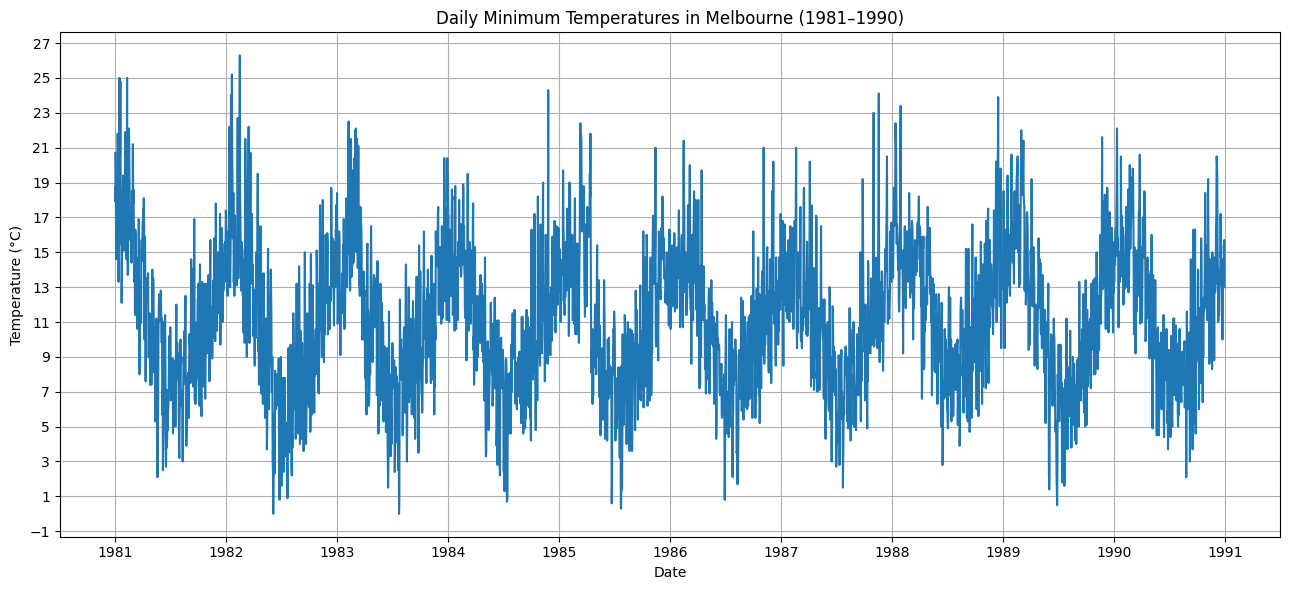

In [67]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택한다.
ts1=ts1.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인한다.
print(ts1[ts1.isna()])

# 다시 그래프를 확인한다.
plt.plot(ts1)

# y축 틱을 적당히 정리 (예: 최소~최대 구간을 2 간격으로 표시)
yticks = np.arange(int(ts1.min()) - 1, int(ts1.max()) + 2, 2)
plt.yticks(yticks)

plt.title("Daily Minimum Temperatures in Melbourne (1981–1990)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

시간 추이에 따라 일정한 평균, 분산, 자기공분산의 패턴이 나타나는 것처럼 보인다.

직관적으로 그래 보이긴 하지만, 시계열 데이터의 통계적 특성을 좀 더 명료하게 시각화해 보겠다.

- 원본, 이동 평균, 이동 표준편차 모두 한 그래프에 표시하여 시각화한다.  
    → 정상 시계열이라면 평균과 표준편차가 시간에 따라 일정하게 유지되어야 함

| 용어                 | 설명                             |
| ------------------ | ------------------------------ |
| **Rolling Mean**   | 일정 구간의 평균값, 추세(Trend)를 시각화     |
| **Rolling Std**    | 일정 구간의 표준편차, 안정성(Variance)을 평가 |
| **Stationary**     | 평균, 분산이 일정한 시계열                |
| **Non-Stationary** | 평균 또는 분산이 시간에 따라 변함            |


In [68]:
# 정성적 정상성 분석 함수

def plot_rolling_statistics(timeseries, window=12):
    """
    시계열 데이터의 정상성을 정성적으로 판단하기 위해
    원본 시계열과 이동 평균(rolling mean), 이동 표준편차(rolling std)를 함께 시각화한다.

    Parameters
    ----------
    timeseries : pandas.Series
        분석할 시계열 데이터 (DatetimeIndex를 가진 Series)
    window : int, optional (default=12)
        이동 평균과 이동 표준편차를 계산할 구간(윈도우)의 크기
        주로 주기 단위(e.g., 월별 데이터의 경우 12개월)를 설정

    Returns
    -------
    None
        시각화 결과를 화면에 출력만 하고, 반환값은 없다.
    """

    # 이동 평균 계산: 일정 기간 동안의 평균값 → 추세 확인
    rolmean = timeseries.rolling(window=window).mean()

    # 이동 표준편차 계산: 일정 기간 동안의 변동성 → 정상성 확인
    rolstd = timeseries.rolling(window=window).std()

    # 시각화: 원본, 이동 평균, 이동 표준편차 모두 한 그래프에 표시
    plt.plot(timeseries, color='blue', label='Original')       # 원본 시계열
    plt.plot(rolmean, color='red', label='Rolling Mean')       # 이동 평균
    plt.plot(rolstd, color='black', label='Rolling Std')       # 이동 표준편차

    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.grid(True)
    plt.tight_layout()
    plt.show(block=False)


- 단기(window=12)와 장기(window=365) 관점에서 안정성 판단
- 평균과 표준편차가 일정하면 정상성 시계열로 간주

>정상 시계열 (stationary): 평균, 분산, 자기공분산이 시간에 따라 일정한 성질

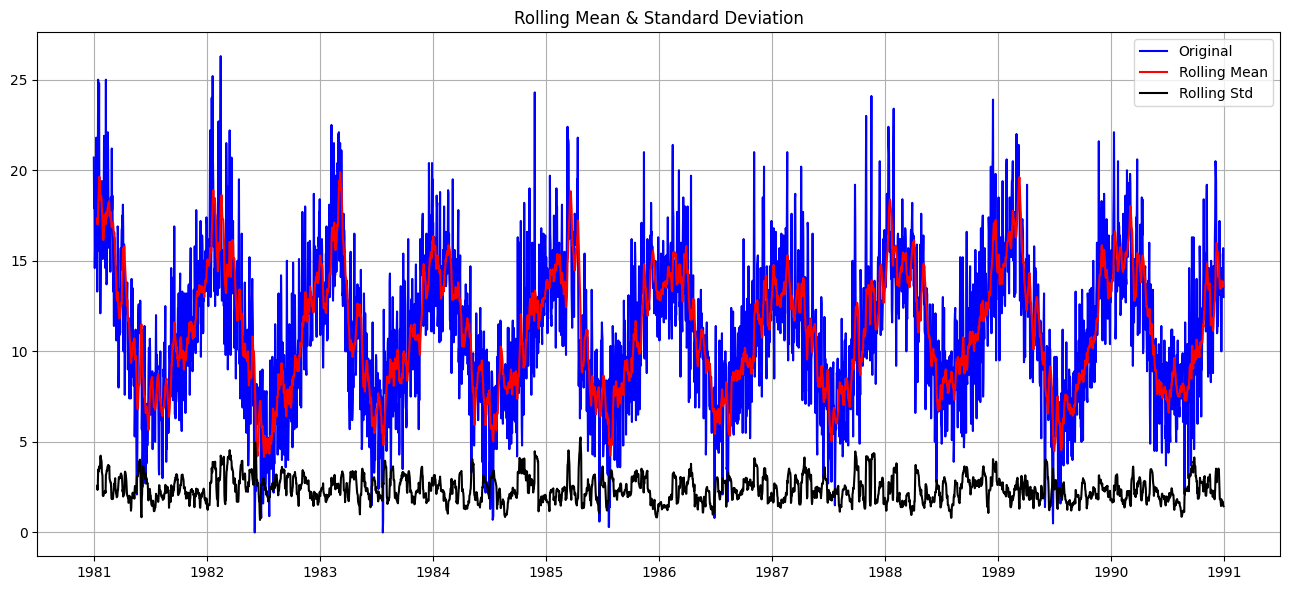

In [69]:
plot_rolling_statistics(ts1, window=12)

**[1] window=12 (단기: 12일 기준 이동 평균 & 표준편차)**

해석:

- 파란색: 원본 데이터 (`Original`)
- 빨간색: 12일 단위의 이동 평균 (`Rolling Mean`)
- 검은색: 12일 단위의 **이동 표준편차** (`Rolling Std`)

관찰 포인트:

- **계절성 존재**: 대략 1년 주기로 온도가 오르락내리락하는 패턴이 뚜렷하다.
- **단기 평균은 일정해 보임**: 빨간선이 크게 위아래로 움직이지 않고 주기적으로 반복된다.
- **단기 표준편차도 안정적**: 검은선(변동성)이 시간에 따라 크게 증가하거나 감소하지 않는다.

결론:

> 단기(window=12) 기준으로 보면 이 시계열은 평균과 분산이 일정해 보이며, 정상 시계열로 추정할 수 있다. (단, 계절성이 있으므로 '완전한' 정상성은 아님)
>

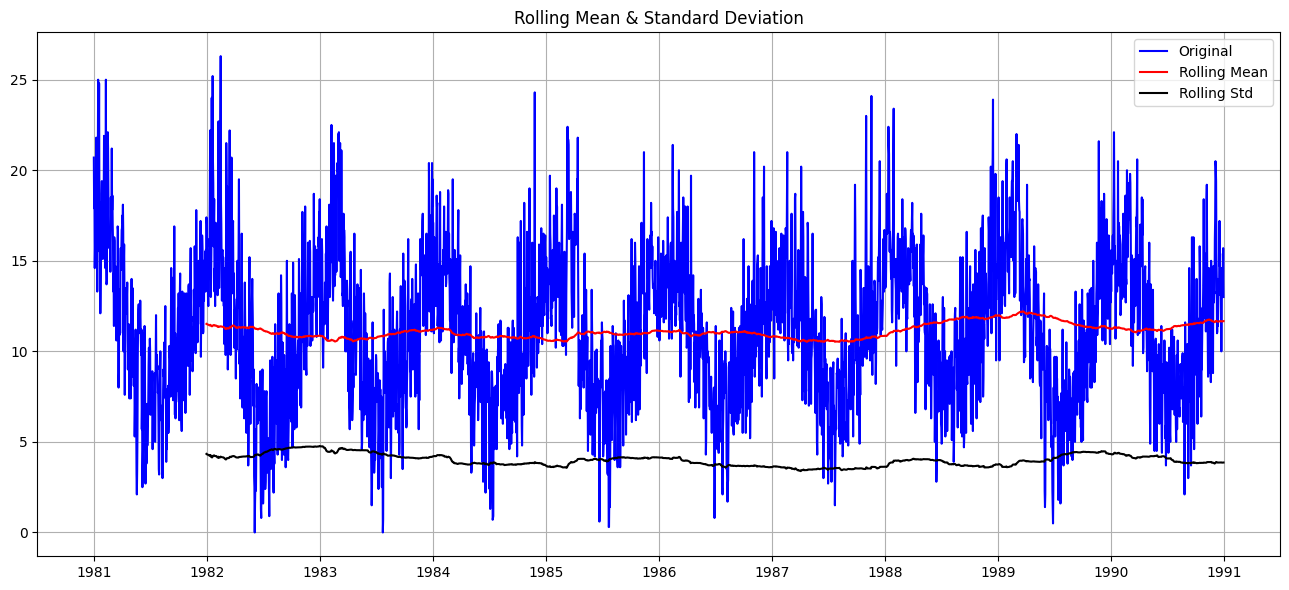

In [70]:
plot_rolling_statistics(ts1, window=365)

**[2] window=365 (장기: 1년 기준 이동 평균 & 표준편차)**

해석:

- 1년 단위 이동 평균(빨간선)이 전체 기간에 걸쳐 거의 일정하게 유지됨
- 1년 단위 이동 표준편차(검은선)도 전체 기간 동안 큰 변화 없음

관찰 포인트:

- 추세가 크지 않고 평균선이 거의 수평 → 장기적으로도 평균이 일정
- 분산 역시 장기적으로 일정해 보임

결론:

> 장기(window=365) 기준에서도 평균과 분산이 안정적이므로, 이 시계열은 추세가 거의 없고 안정된 계절성을 가진 정상 시계열로 해석할 수 있습니다.
>

>계절성이 있다는 이유만으로 비정상이라고 단정할 수 없다. 평균과 분산이 일정하고, 계절 패턴이 반복적으로 안정적이라면 "계절적으로 정상(seasonally stationary)"이라고 부르며, 이는 ARIMA, SARIMA 모델에서 전처리나 모형 선택의 근거가 된다.

시각화한 결과만 놓고 보면 이 시계열 데이터가 정상성을 띈다고 명확하게 결론을 내릴 수그렇다고 말할 수도 있겠지만, 명확하게 단정 지으려면 좀 더 통계적인 접근이 필요할 것입니다.

이후 스텝에서 다루기로 하고, 일단 다른 시계열 데이터의 패턴과 비교해 본다.

<br>

### 다른 데이터에 대해서도 비교

이번에는 International airline passengers 데이터셋이다.

월별 항공 승객 수(단위: 천 명)의 시계열 데이터인데 기온 변화 데이터셋과는 좀 다른 패턴이 나타나지 않을까 예상된다.






In [71]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, index_col='Month', parse_dates=True).fillna(0)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


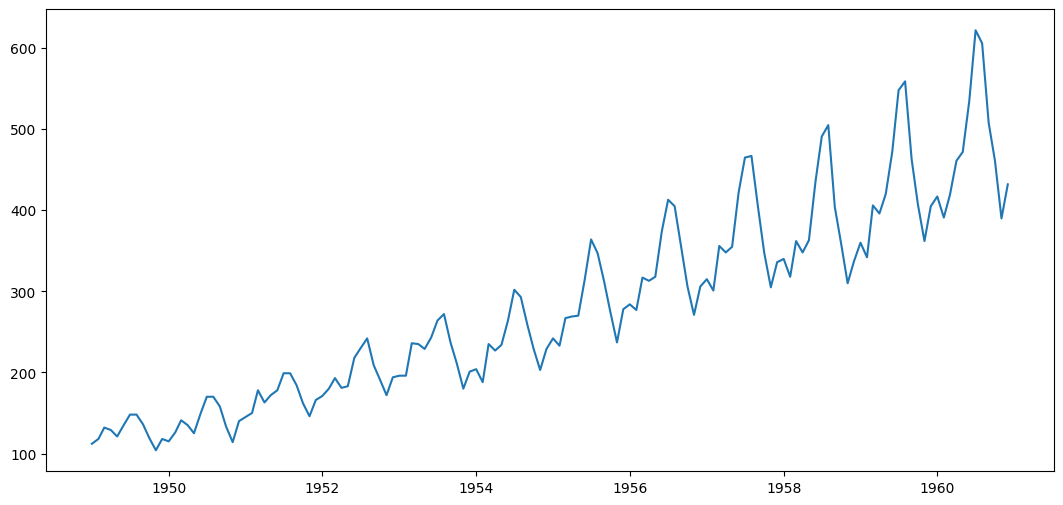

In [72]:
ts2 = df['Passengers']
plt.plot(ts2)

직관적으로 봐도 온도 변화 데이터셋과는 다른 패턴이 보인다. 시간의 추이에 따라 시계열의 평균과 분산이 지속적으로 커지는 패턴을 보인다.

rolling statistics를 추가해서 시각화해 보겠습니다.

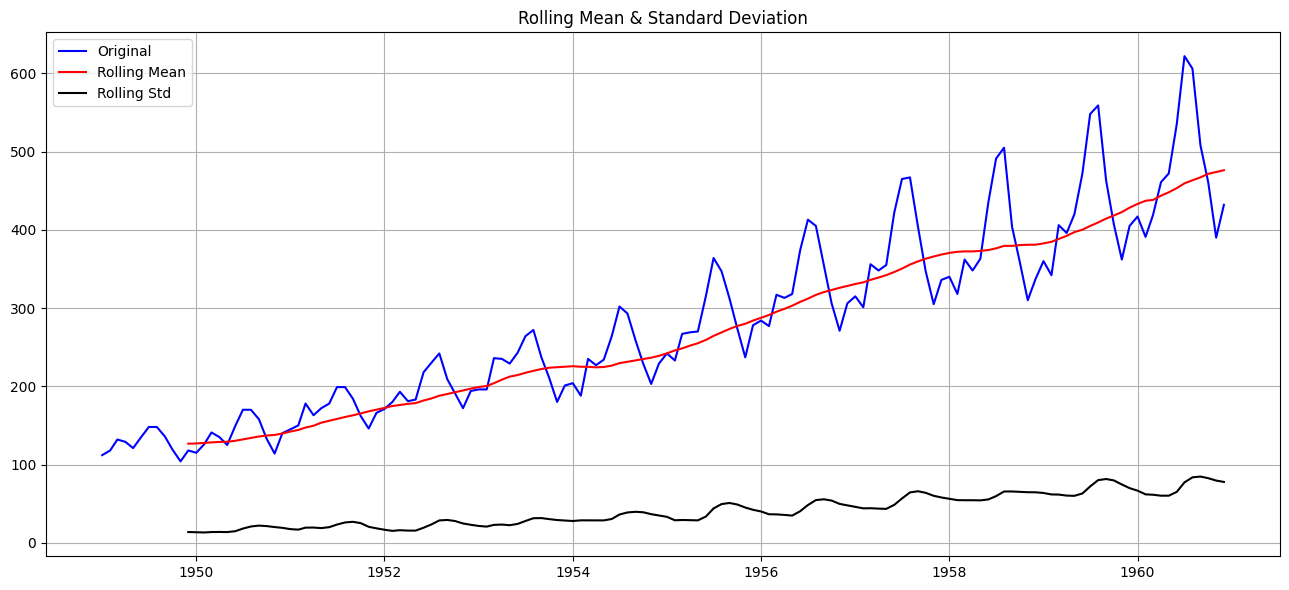

In [74]:
plot_rolling_statistics(ts2, window=12)

이렇게 시간의 추이에 따라 평균과 분산이 증가하는 패턴을 보인다면 이 시계열 데이터는 비정상성을 보인다고 정성적인 결론을 내려볼 수 있다.

시계열 데이터의 정상성을 평가하기 위해 보다 정량적인 방법을 사용해 보겠다.

---


<br>
<br>
<br>

# 9-5. Stationary 여부를 체크하는 통계적 방법

### statsmodel 패키지와 adfuller 메서드

statsmodels 패키지는 R에서 제공하는 통계검정, 시계열분석 등의 기능을 파이썬에서도 이용할 수 있도록 하는 강력한 통계 패키지이다.

statsmodels 패키지에서 제공하는 adfuller 메서드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행해 보겠다.

<br>

ADF 테스트란?

- 귀무가설(H₀): 시계열은 **비정상(non-stationary)**이다.
- 대립가설(H₁): 시계열은 **정상(stationary)**이다.
- p-value가 작으면 (보통 0.05 미만) → 귀무가설 기각 → **정상**

In [75]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    """
    시계열 데이터의 정상성(stationarity)을 정량적으로 판단하기 위해
    Augmented Dickey-Fuller (ADF) 검정을 수행하고 결과를 출력한다.

    ADF 검정은 시계열이 단위근(unit root)을 포함하는지 여부를 검정하는 통계적 방법이다.
    - 귀무가설(H₀): 시계열은 비정상성(\non-stationary)을 가진다.
    - 대립가설(H₁): 시계열은 정상성(stationary)을 가진다.

    Parameters
    ----------
    timeseries : pandas.Series
        정상성 여부를 검정할 시계열 데이터

    Returns
    -------
    None
        테스트 결과를 콘솔에 출력하며, 반환값은 없다.
    """

    # ADF 테스트 실행, autolag='AIC'는 AIC 기준으로 최적 lag를 자동 선택
    dftest = adfuller(timeseries, autolag='AIC')

    print('Results of Dickey-Fuller Test:')

    # 테스트 통계량, p-value, 사용된 lag 수, 사용된 관측치 수 추출 및 시리즈화
    dfoutput = pd.Series(dftest[0:4], index=[
        'Test Statistic',              # ADF 검정 통계량
        'p-value',                     # 귀무가설 기각 여부 판단 기준
        '#Lags Used',                  # 자동으로 선택된 랙 개수
        'Number of Observations Used'  # 유효한 관측치 수
    ])

    # 각 신뢰수준(1%, 5%, 10%)에 대한 임계값 추가
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value

    # 결과 출력
    print(dfoutput)

정성적으로 분석해 보았던 두 시계열에 대한 Augmented Dickey-Fuller Test를 수행해 본다.

In [76]:
augmented_dickey_fuller_test(ts1)

Results of Dickey-Fuller Test:
Test Statistic                   -4.444653
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3626.000000
Critical Value (1%)              -3.432155
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64


ts1(Daily Minimum Temperatures in Melbourne)시계열이 안정적이지 않다는 귀무가설은 p-value가 거의 0에 가깝게 나타났다.
따라서 이 귀무가설은 기각되고, 이 시계열은 정상 시계열이라는 대립가설이 채택된다.  

정성적 분석(rolling 평균, 표준편차)과도 일치하는 결과이다.

In [77]:
augmented_dickey_fuller_test(ts2)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


ts2(International airline passengers) 시계열이 안정적이지 않다는 귀무가설은 p-value가 거의 1에 가깝게 나타났다.
귀무가설을 기각할 수는 없게 되었으므로 이 시계열이 정상 시계열이라고 말할 수 없다.  

시각적으로도 평균·분산이 증가하던 패턴과 일치합니다.

---

<br>
<br>
<br>

# 9-6. Stationary하게 만들 방법은 없을까?

비정상 시계열이라고 판단한 International airline passengers 시계열을 정상화해야 한다.

1. 정성적인 분석을 통해 보다 정상적인 특성을 가지도록 기존의 시계열 데이터를 가공/변형하는 시도

2. 시계열 분해(Time series decomposition) 기법을 적용

<br>

방법 1: 데이터 변환

- 로그 변환, 제곱근, Box-Cox 변환 등

방법 2: 차분(Differencing)

- 현재 값과 바로 전 시점의 차를 계산
- 추세나 계절성을 제거하는 데 유용

방법 3: 시계열 분해 (Time Series Decomposition)

- 시계열을 **추세(trend)**, **계절성(seasonal)**, **잔차(residual)**로 분리하여 분석

### 1. 로그함수 변환

가장 먼저 고려해 볼 수 있는 것은 시간 추이에 따라 분산이 점점 커지고 있다는 점이다. 시계열이 이런 특성을 보일 경우에는 로그함수로 변환을 해주는 것이 도움이 된다.

- 원래 데이터(ts2)는 시간이 지남에 따라 분산이 커짐 (즉, 변동폭 증가)
- 로그를 취하면 값이 커질수록 압축 → 분산 안정화 효과

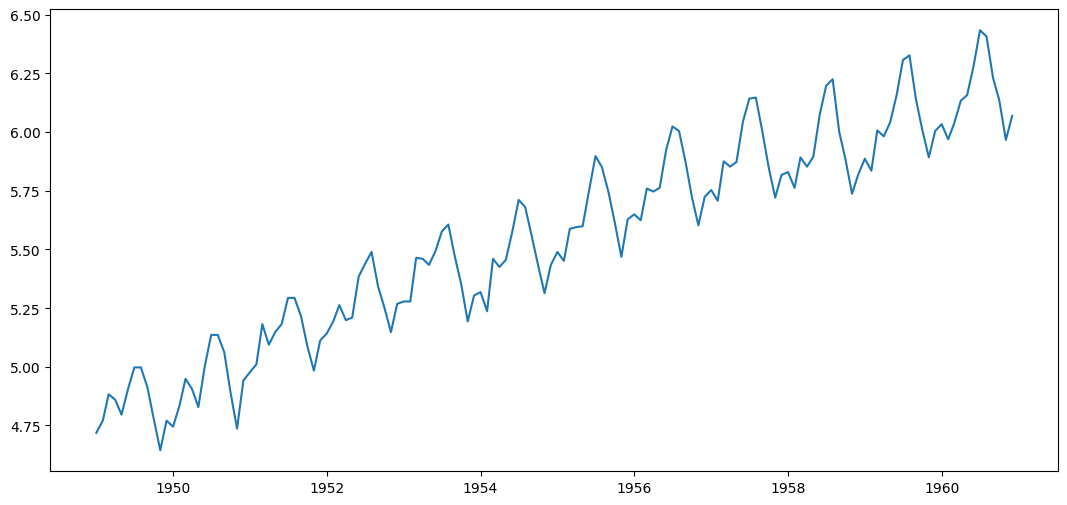

In [78]:
ts_log = np.log(ts2)
plt.plot(ts_log)

로그 변환의 효과를 따져 보기 위해 Augmented Dickey-Fuller Test를 수행한다.






In [79]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


- p-value가 원래 1.0 → 0.42로 감소

- 귀무가설(비정상성)을 완전히 기각할 수는 없지만, 정성적으로도 이전보다 안정성에 가까워짐

    → 분산 안정에는 효과 있음, 하지만 추세(평균 증가)는 여전히 존재

<br>

### 2. Moving average 제거 - 추세(Trend) 상쇄하기

시계열 분석에서 시간 추이에 따라 나타나는 평균값 변화를 추세(trend)라고 한다.

이 변화량을 제거해 주려면 거꾸로 Moving Average, 즉 rolling mean을 구해서 ts_log에서 빼줄 수 있다.

- **추세(trend)**를 제거하기 위해 12개월 단위로 이동 평균선을 계산
- 빨간선이 전체 평균 변화 추이를 보여줌

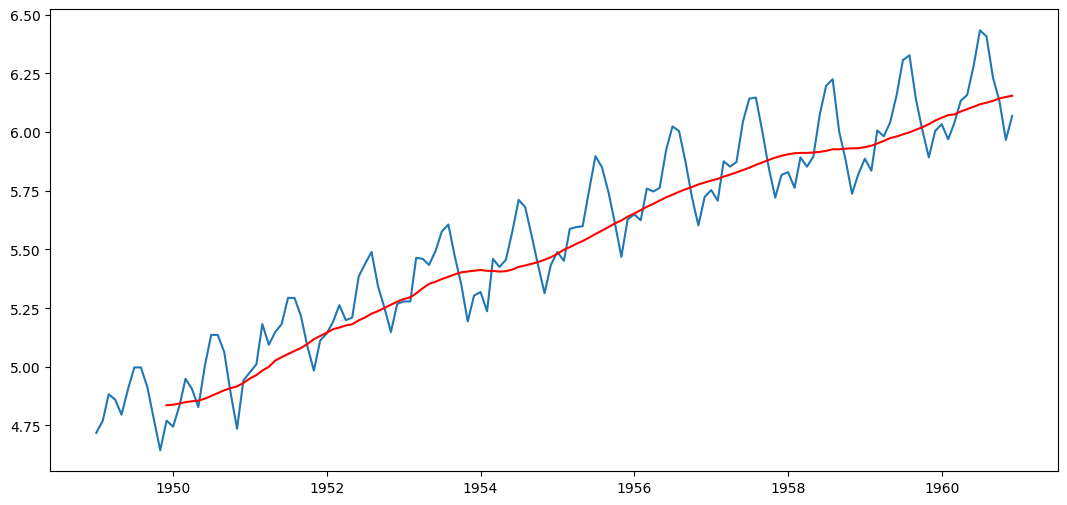

In [80]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

이동 평균을 빼서 추세 제거

추세 제거 방식:
- 시계열 원본 - 이동 평균 = 추세를 제거한 잔차
- 즉, 전체 흐름에서 평균적인 패턴을 제거한 값



In [81]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

,Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


 Moving Average 계산 시 (windows size=12인 경우) 앞의 11개의 데이터는 Moving Average가 계산되지 않으므로 ts_log_moving_avg에 결측치(NaN)가 발생한다.

이 결측치들은 향후 Dicky-Fuller Test 시에 에러를 발생시킬 것이므로 이를 데이터셋에서 제거해 준다.

- rolling(window=12)이기 때문에 처음 11개는 NaN이 생김
- NaN은 ADF 테스트나 예측 모델에서 에러를 유발하므로 제거 필요



In [82]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

,Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
1950-05-01,-0.027529
1950-06-01,0.139881
1950-07-01,0.260184
1950-08-01,0.248635


| 단계     | 목표           | 방법                 | 효과          |
| ------ | ------------ | ------------------ | ----------- |
| 로그 변환  | 분산 안정화       | `np.log()`         | 분산 감소       |
| 이동 평균  | 추세 제거        | `rolling().mean()` | 평균 일정화      |
| 차분/보정  | 평균·분산 둘 다 제거 | 원본 - 이동평균          | 정상성에 더 가까워짐 |
| 결측치 제거 | 분석 오류 방지     | `dropna()`         | 안정된 결과 확보   |


<br>

### 3. 정성/정량적 분석하기

ts_log_moving_avg를 정성, 정량적으로 분석해 본다.

- 이동평균 제거 후 정상성 재검정

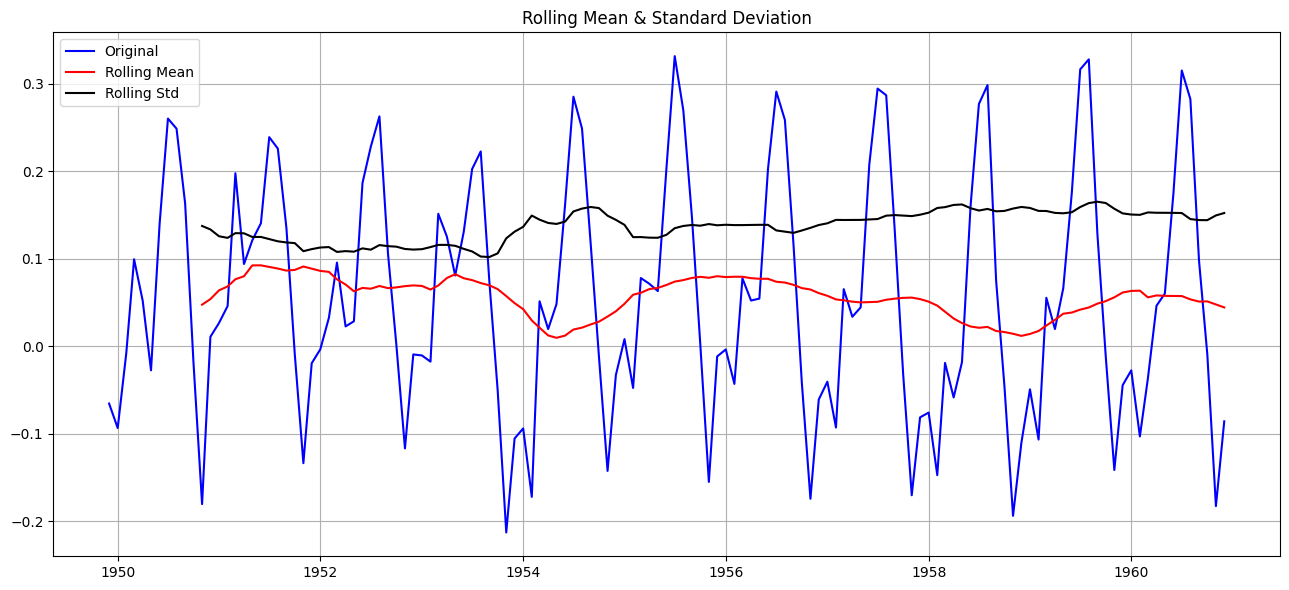

In [83]:
plot_rolling_statistics(ts_log_moving_avg)

In [84]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


- p-value ≈ 0.02
    → 귀무가설 기각 가능 → 정상성 확보됨
- 평균·분산이 시각적으로 일정함
- 95% 신뢰수준에서 stationary라고 판단 가능

그러나 지금까지의 접근에서 한 가지 숨겨진 문제점이 있다. Moving Average를 계산하는 window=12로 정확하게 지정해 주어야 한다는 점이다.

만약 위 코드에서 window=6을 적용하면 어떤 결과가 나올까?

In [85]:
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)

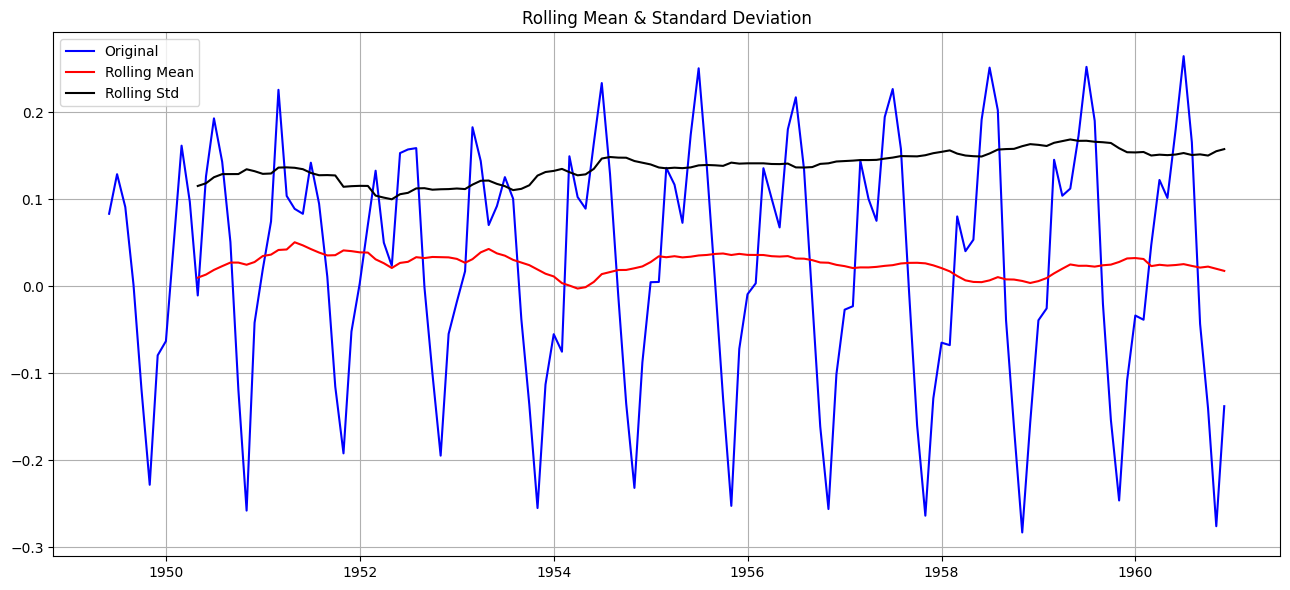

In [86]:
plot_rolling_statistics(ts_log_moving_avg_6)

In [87]:
augmented_dickey_fuller_test(ts_log_moving_avg_6)

Results of Dickey-Fuller Test:
Test Statistic                  -2.273822
p-value                          0.180550
#Lags Used                      14.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64


그래프를 정성적으로 분석해서는 window=12일 때와 별 차이를 느낄 수 없지만 Augmented Dickey-Fuller Test의 결과 p-value는 0.18 수준이어서 아직도 안정적 시계열이라고 말할 수 없게 되었다.

이 데이터셋은 월 단위로 발생하는 시계열이므로 12개월 단위로 주기성이 있기 때문에 window=12가 적당하다는 것을 추측할 수도 있을 것 같지만, moving average를 고려할 때는 rolling mean을 구하기 위한 window 크기를 결정하는 것이 매우 중요하다는 것을 기억해야 한다.


> 이동 평균을 통한 추세 제거 시, window 크기 선택이 매우 중요
>
>
> 이 데이터는 **월별 시계열**이므로 `window=12`가 합리적
>
> → **도메인 지식 + 실험적 검증**이 필요


<br>

이제 시간의 추이에 따라 평균이 증가하는 trend를 제거하였습니다. 그러나 여전히 안정적인 시계열이라고 하기에는 걸리는 부분이 있다.

<br>

### 4. 차분(Differencing) - 계절성(Seasonality) 상쇄하기

- 차분이란: 현재 값 - 이전 값을 구해 변화량만 남기는 기법

Trend에는 잡히지 않지만 시계열 데이터 안에 포함된 패턴이 파악되지 않은 주기적 변화는 예측에 방해가 되는 불안정성 요소이다. 이것은 Moving Average 제거로는 상쇄되지 않는 효과이고, 계절적/주기적 패턴을 계절성(Seasonality)라고 한다.

이런 패턴을 상쇄하기 위해 효과적인 방법에는 차분(Differencing)이 있다. 마치 미분(Differentiation)을 떠올리게 하는 개념인데, 시계열을 한 스텝 앞으로 시프트한 시계열을 원래 시계열에 빼 주는 방법이다. 이렇게 되면 남은 것은 현재 스텝 값 - 직전 스텝 값이 되어 **정확히 이번 스텝에서 발생한 변화량을 의미**하게 된다. 이 변화량 시계열은 어떤 패턴을 보이게 될까?

우선 시프트한 시계열과 원본 시계열에 대한 그래프를 그려본다.

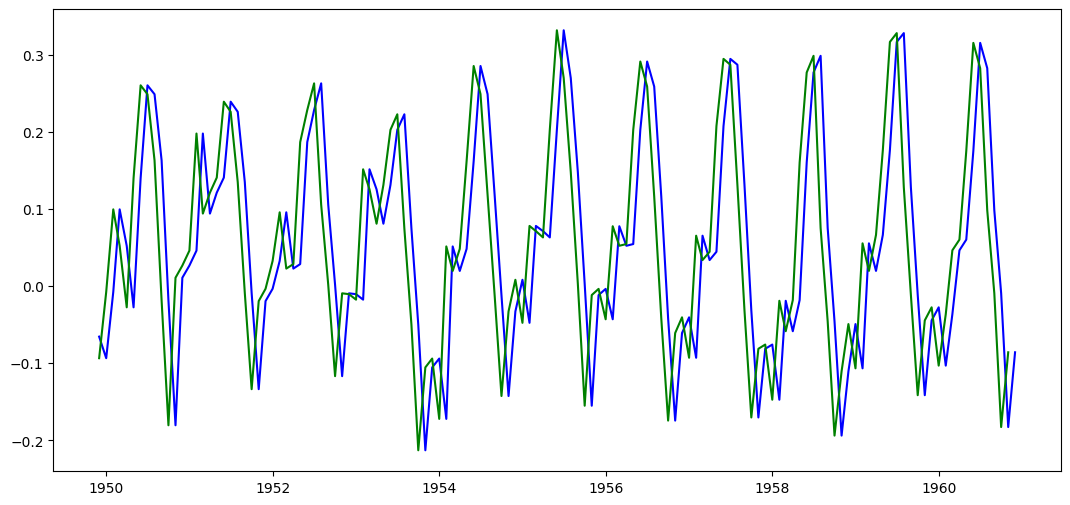

In [88]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift(-1)

plt.plot(ts_log_moving_avg, color='blue')  # 원본
plt.plot(ts_log_moving_avg_shift, color='green')  # 한 칸 뒤로 민 버전

- 파란선과 초록선을 비교하여 차분 전후의 시계열 패턴을 시각적으로 이해
- 다음 단계에서 실제로 차분 계산 후 ADF 테스트로 안정성 검증



원본 시계열에서 시프트한 시계열을 뺀 값을 그래프로 표현해 본다.

- 1차 차분: 현재 값 - 이전 값
- 목적: 계절성 제거 (Seasonality offset)
- 시각적으로 잔차(변화량) 시계열이 안정적인 패턴을 가지는지 확인




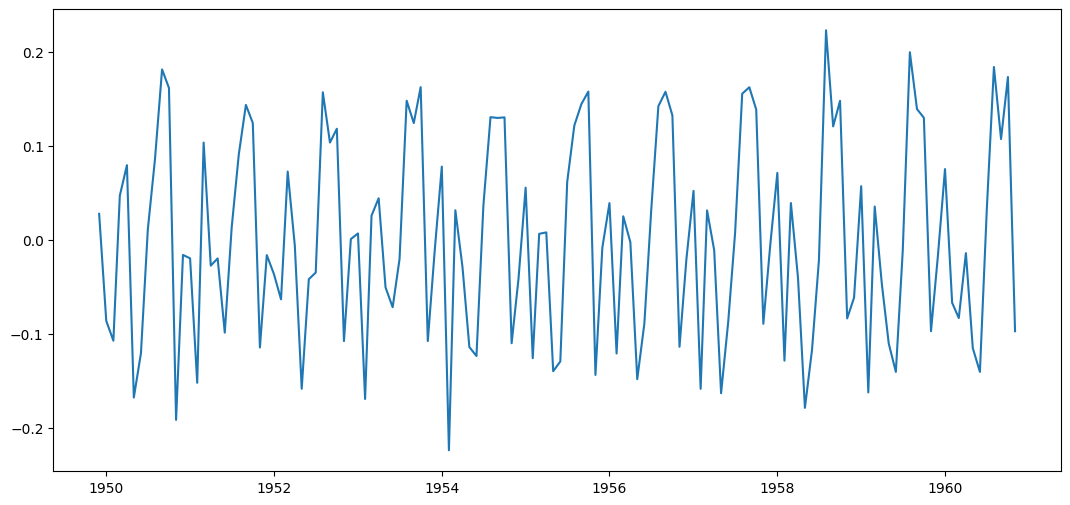

In [89]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 파악해 본다.

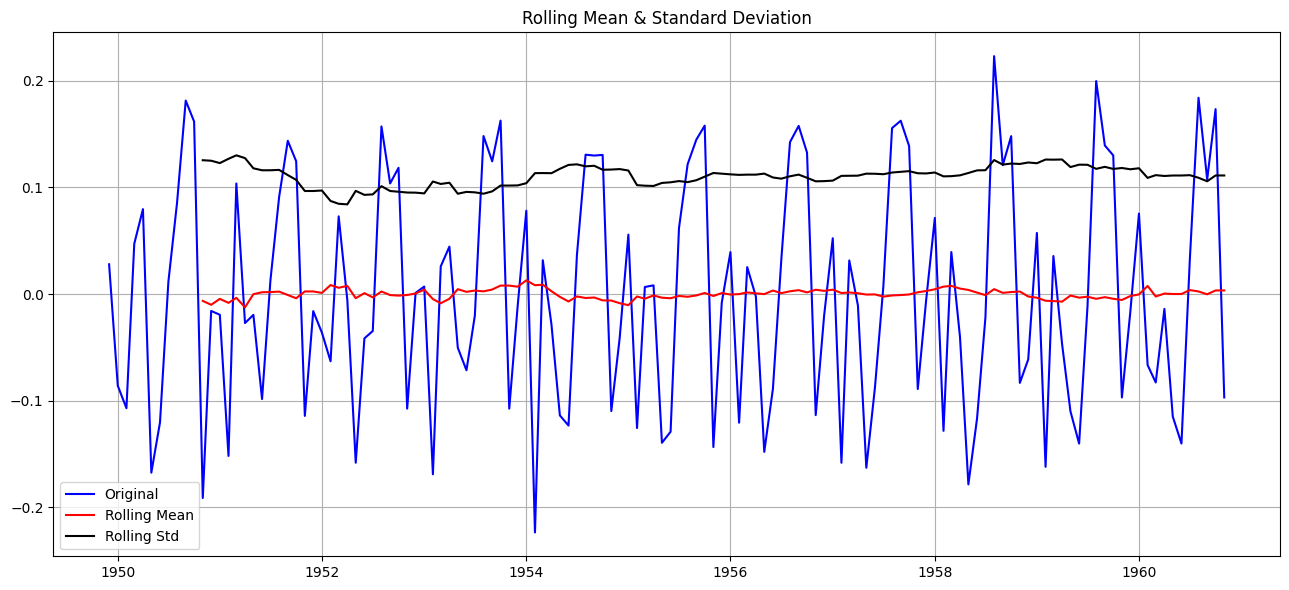

In [90]:
plot_rolling_statistics(ts_log_moving_avg_diff)

- Rolling Mean과 Std가 수평에 가까워졌다면 정성적으로 정상성 확보

차분의 효과가 어떠했는지 알아보기 위해 Augmented Dickey-Fuller Test를 수행해 본다.

In [91]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -3.912981
p-value                          0.001941
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


- p-value ≈ 0.0019  
    → 극히 낮은 값 → 귀무가설 강하게 기각 → 완전한 정상성 확보

- 이전: p=0.42 → 0.02 → 0.0019  
    → 차분이 정상성 확보에 매우 효과적이라는 것을 보여준다.

이동평균을 빼 주어 추세(Trend)를 제거하고 난 시계열에다가 1차 차분(1st order differencing)을 적용하여 Seasonality 효과를 다소 상쇄한 결과, p-value가 약 0.022 에서 0.0019로 1/10 정도로 줄었다.

데이터에 따라서는 2차 차분(2nd order differencing, 차분의 차분), 3차 차분(3rd order differencing, 2차 차분의 차분)을 적용하면 더욱 p-value를 낮출 수도 있다.



<br>

### 5. 시계열 분해(Time series decomposition)

statsmodels 라이브러리 안에는 seasonal_decompose 메서드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있는 기능이 있다. 이 기능을 활용하면 위에서 직접 수행했던 moving average 제거, differencing 등을 거치지 않고도 훨씬 안정적인 시계열을 분리해 낼 수 있게 된다.

위에서 구했던 로그 변환 단계(ts_log)에서부터 시작한다.

- seasonal_decompose() 함수로 시계열을 구성 성분으로 분리

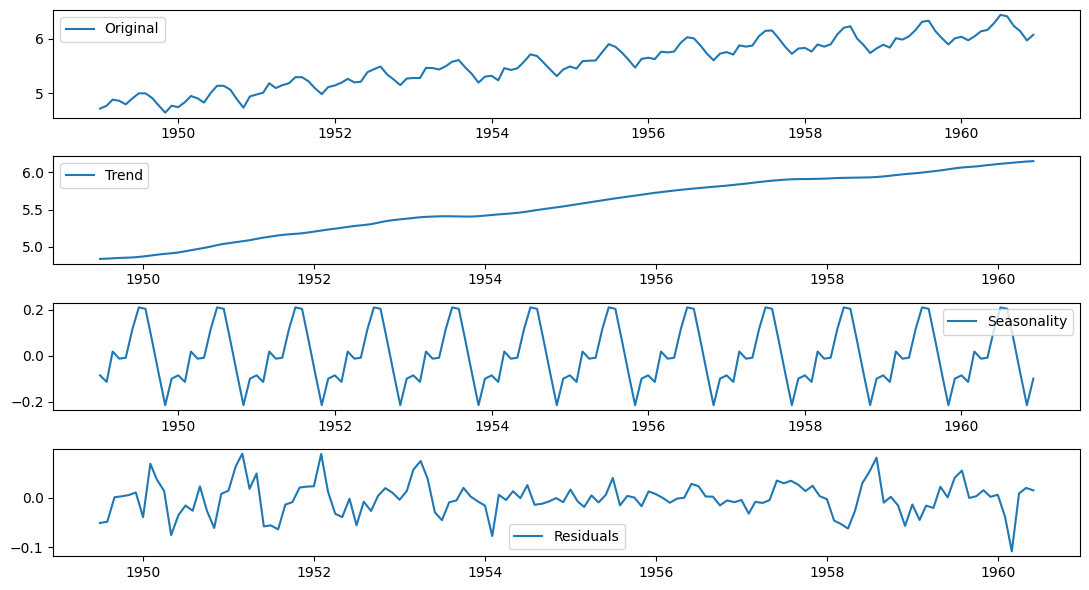

In [92]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend        # 추세 (시간 추이에 따라 나타나는 평균값 변화)
seasonal = decomposition.seasonal  # 계절성 (패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid     # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

| 구성요소        | 의미                    |
| ----------- | --------------------- |
| Original    | 로그 변환한 원본 시계열         |
| Trend       | 장기 추세 (시간에 따른 평균 변화)  |
| Seasonality | 반복되는 계절 패턴            |
| Residuals   | 나머지: 순수한 노이즈 + 예측 가능성 |


Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지를 Residual이라고 한다. 뒤집어서 말하면 Trend+Seasonality+Residual=Original 이 성립한다는 뜻이다. 이러한 Decomposing은 시계열 데이터를 이해하는 중요한 관점을 제시해 준다.

그렇다면 이제 Residual에 대해 안정성 여부를 따져 보겠다.

- 시계열 분해 후 잔차(Residual) 분석

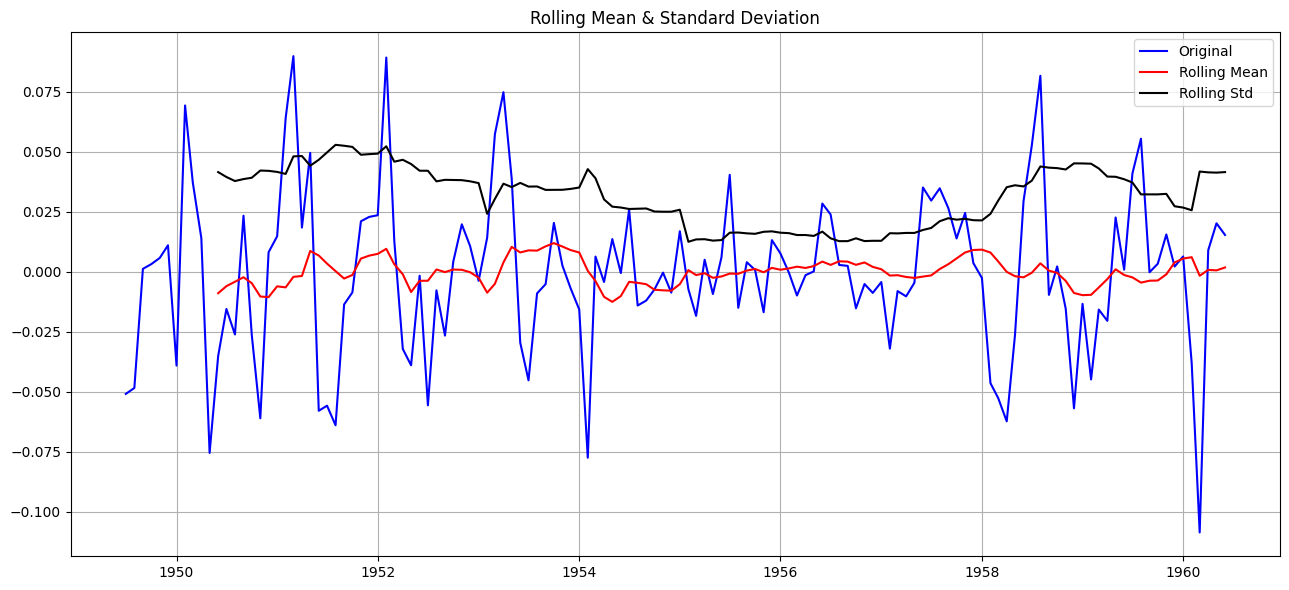

In [93]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [94]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보여준다. 이 정도면 확실히 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있겠다.

굳이 애써 직접 Trend, Seasonality를 제거하려고 애쓸 필요가 없이 바로 Time Series Decomposing을 시도하는 게 더 낫지 않았을까? 물론 그렇긴 하지만, 이렇게 Trend와 Seasonality를 제거해 주는 것이 어떤 효과를 발휘하게 되는지를 단계적으로 확인하는 과정도 필요하다.

>복잡하게 로그 변환 + 이동평균 + 차분을 하지 않아도 seasonal_decompose()로 추세와 계절성을 분해한 잔차를 이용하면
빠르고 정확하게 안정된 시계열을 확보할 수 있다.

---

<br>
<br>
<br>

# 9-7. ARIMA 모델의 개념

statsmodels에서 제공하는 ACF와 PACF 플로팅 기능을 사용한다.

- ARIMA 모델을 위한 ACF / PACF 분석

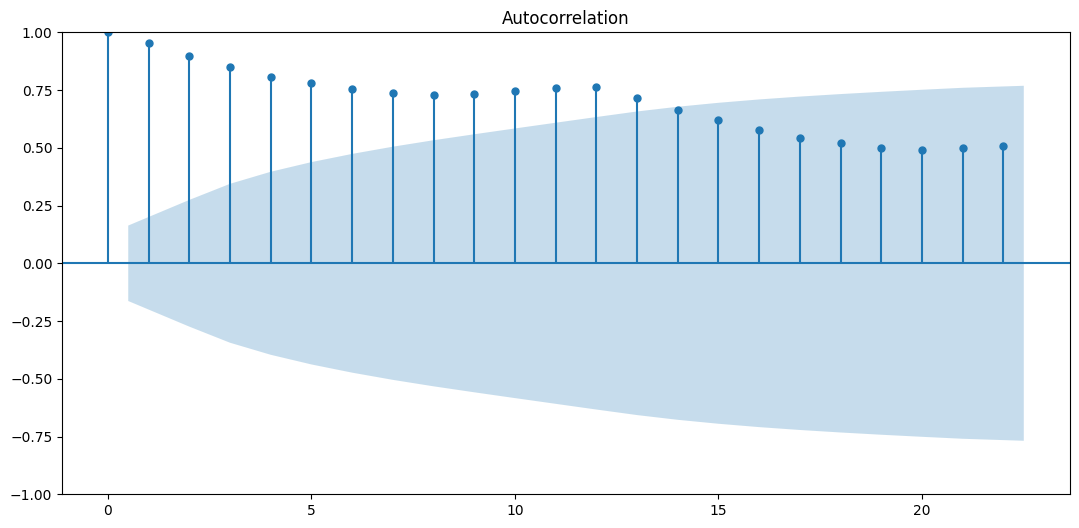

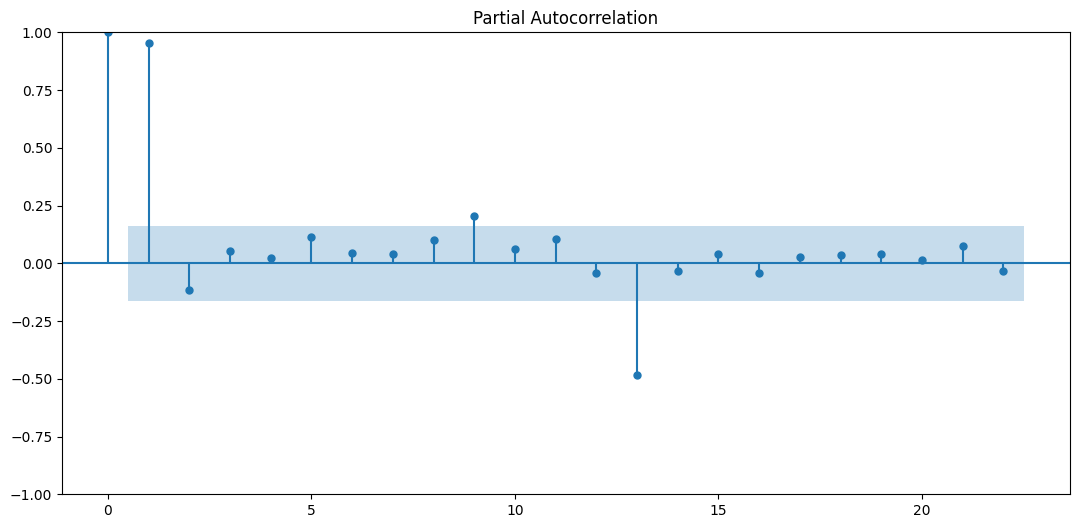

In [95]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기 - 자기상관
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기 - 부분 자기상관
plt.show()

| 그래프      | 급격히 끊기는 위치       | 해석                |
| -------- | ---------------- | ----------------- |
| **ACF**  | lag q 이후 급격히 줄어듦 | → **MA(q)** 모델 적합 |
| **PACF** | lag p 이후 급격히 줄어듦 | → **AR(p)** 모델 적합 |

<br>

- **ACF (Autocorrelation Function)**: 과거 관측치와의 관계
    - → MA(q) 결정 근거
- **PACF (Partial ACF)**: 특정 시점 전후의 직접 관계만 추출
    - → AR(p) 결정 근거

해석 예시:

- PACF: lag=1에서만 뚜렷함 → **p=1**
- ACF: 점차 감소 → MA 효과는 미약 → **q=0 또는 작게**

<br>

PACF 그래프를 볼 때 p=1이 매우 적합하고, p=14에서도 유의하다고 보인다. p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있다. PACF가 0이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻이다.

반면 ACF는 점차적으로 감소하고 있어서 AR(1) 모델에 유사한 형태를 보이고 있다. q에 대해서는 적합한 값이 없어 보인다. MA를 고려할 필요가 없다면 q=0으로 둘 수 있다. 하지만 q를 바꿔 가면서 확인해 보는 것도 좋겠다.  
- ACF가 천천히 감소하고 있음 (지속적인 양의 자기상관)   
    → 서서히 감쇠하는 패턴  
    → 이는 AR(자기회귀) 성분이 강한 시계열의 특징  
    → q 값을 작게 (예: 0 또는 1) 잡는 것이 적절

d를 구하기 위해서는 좀 다른 접근이 필요하다. d차 차분을 구해 보고 이때 시계열이 안정된 상태인지를 확인해 보아야 한다.

<br>

- 차분 횟수 d 결정 (추세·계절성 제거 단계 수)

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


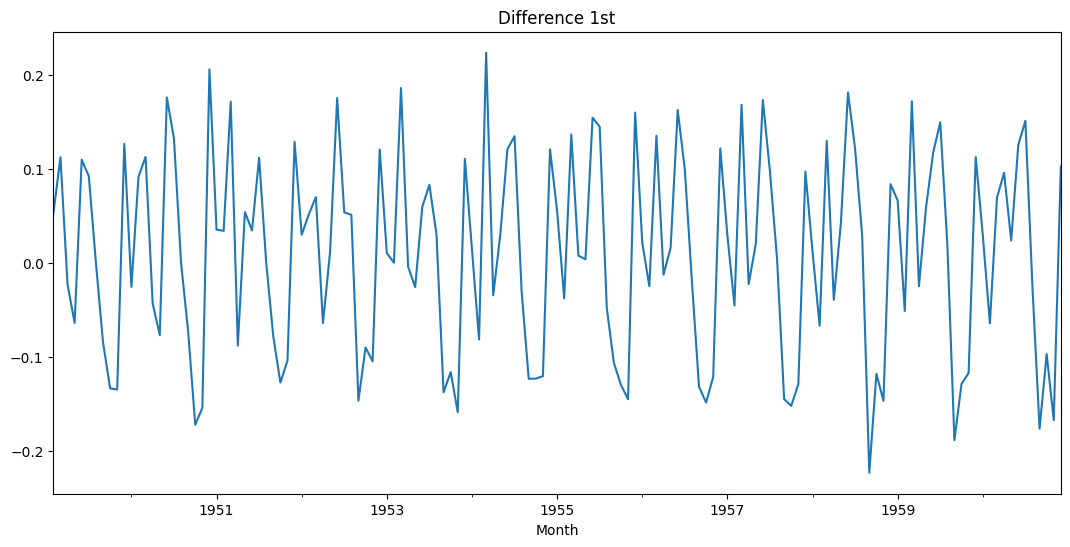

In [96]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


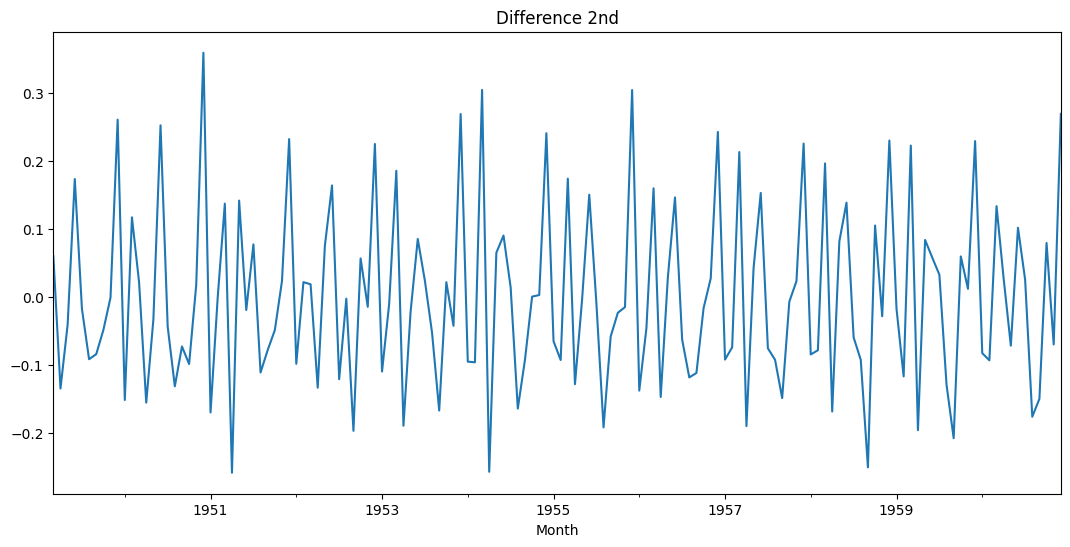

In [54]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

- 1차 차분: p ≈ 0.05 이상 → 다소 불확실
- 2차 차분: p ≈ 0.01 이하 → 확실한 정상성 확보

권장:
>보수적으로 d=1부터 시도
모델 성능 확인 후 d=2로 조정 가능

이번 경우에는 1차 차분을 구했을 때 약간 애매한 수준의 안정화 상태를 보였다. 2차 차분을 구했을 때는 확실히 안정화 상태였지만 이번 경우에는 d=1로 먼저 시도해 볼 수 있겠다. d 값도 바꿔 가면서 최적의 값을 찾아보기를 권장한다.

| 구성 요소 | 의미           | 결정 방법          | 예시 값   |
| ----- | ------------ | -------------- | ------ |
| `p`   | AR(자기회귀) 차수  | PACF에서 lag값 확인 | 1      |
| `d`   | 차분 횟수        | 안정성 확보되는 차분 횟수 | 1 or 2 |
| `q`   | MA(이동 평균) 차수 | ACF에서 lag값 확인  | 0 or 1 |


<br>

### 학습 데이터 분리

아래와 같이 시계열 데이터에서 학습 데이터와 테스트 데이터를 분리한다. 분리 비율은 학습과 테스트에 9:1로 하겠다. 시계열 예측이니만큼 가장 나중 데이터를 테스트용으로 사용하는 것이 타당하다.


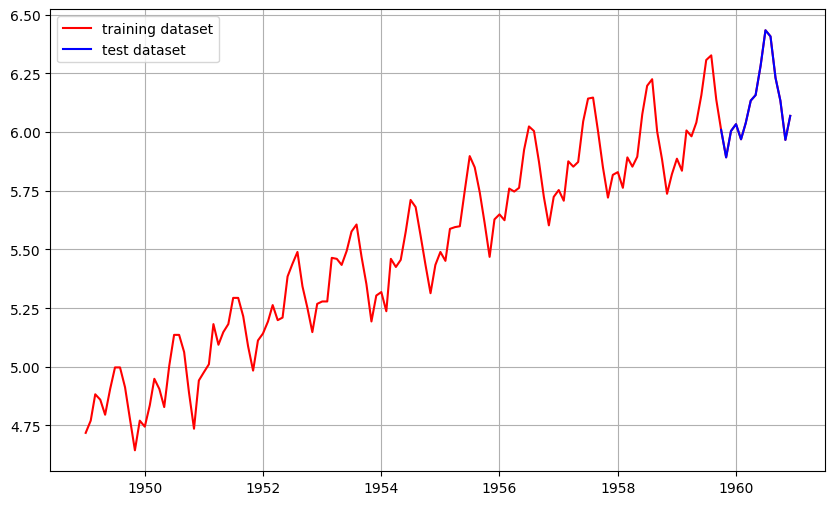

In [97]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [98]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Month
1949-01-01    4.718499
1949-02-01    4.770685
Name: Passengers, dtype: float64
(129,)
(15,)


위와 같이 시각화로 시계열 분할 상태를 확인해 보았다.

---


<br>
<br>
<br>

# 9-8. ARIMA 모델 훈련과 추론

ARIMA 모델을 훈련하는 것은 아래와 같이 간단하다.

- ARIMA(p, d, q): p=14, d=1, q=0을 설정  
- .fit()으로 모델 학습
- summary()에서 각 계수의 유의성(p-value), AIC, BIC 등을 확인 가능

| 구성요소  | 의미                     | 설명                                                  |
| ----- | ---------------------- | --------------------------------------------------- |
| **p** | Autoregressive (AR) 차수 | 과거 값(자기 회귀)의 몇 시점 전까지를 사용할지 결정<br>→ PACF로 추정        |
| **d** | Differencing (차분) 횟수   | 데이터의 **비정상성 제거**를 위해 몇 번 차분할지를 의미<br>→ ADF test로 판단 |
| **q** | Moving Average (MA) 차수 | 과거 예측 오차의 몇 시점 전까지를 사용할지 결정<br>→ ACF로 추정            |




In [123]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(14, 1, 0))  # (p, d, q)
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  129
Model:                ARIMA(14, 1, 0)   Log Likelihood                 219.899
Date:                Tue, 27 May 2025   AIC                           -409.798
Time:                        06:04:59   BIC                           -367.018
Sample:                    01-01-1949   HQIC                          -392.416
                         - 09-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2663      0.081     -3.276      0.001      -0.426      -0.107
ar.L2         -0.0077      0.108     -0.071      0.943      -0.220       0.205
ar.L3          0.0100      0.045      0.220      0.8

ARIMA 모델이 훈련 결과를 시각적으로 확인해 보겠다.

- 훈련 구간 예측값과 실제값을 비교
- 예측이 잘 따라가고 있는지 시각적으로 확인

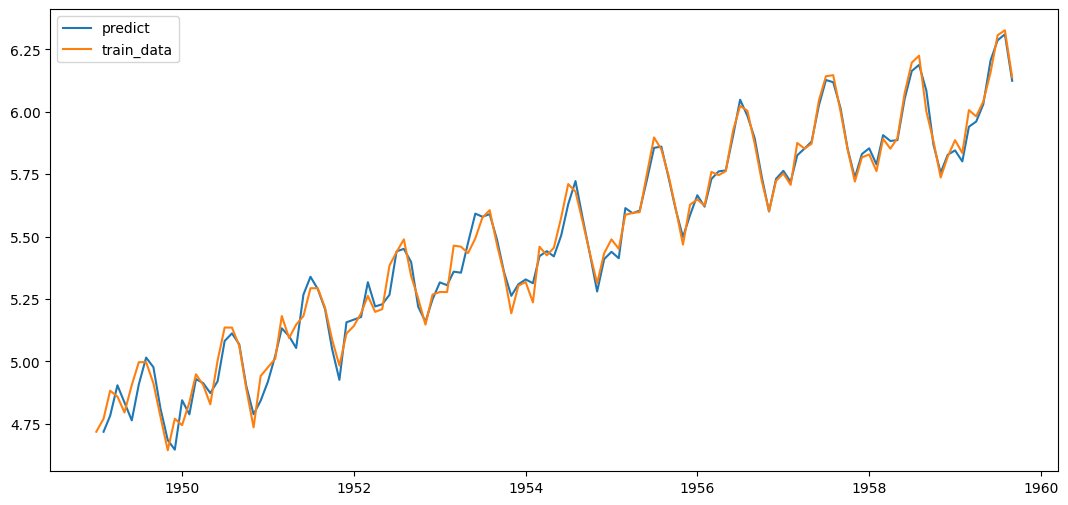

In [124]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측해 본다.

- .forecast()로 향후 시점에 대한 예측값을 생성
- alpha=0.05 → 95% 신뢰구간 기반
- 실제 테스트 데이터와 예측값을 시각적으로 비교

성능이 잘 나올 경우:
>예측선이 테스트 데이터와 비슷한 경향을 가지며, 급격한 이탈 없이 잘 따라간다.

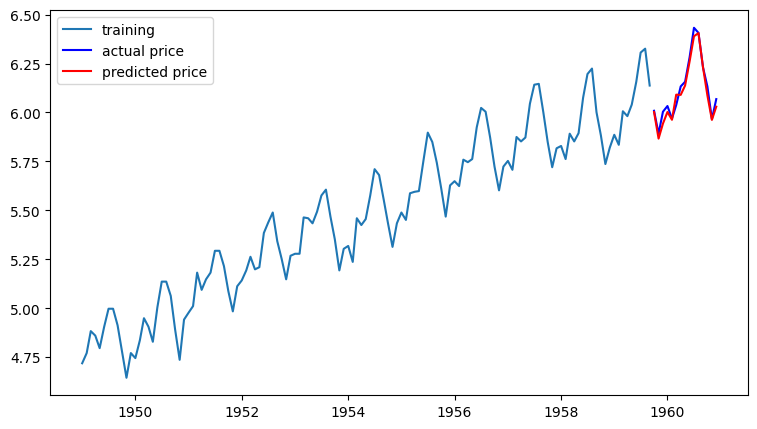

In [125]:
model = ARIMA(train_data, order=(14, 1, 0))  # p값을 14으로 테스트
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

- ARIMA 모델링 프로세스

| 단계 | 설명 |
| --- | --- |
| 1. 안정성 확보 | 로그 변환, 차분, 분해 등 |
| 2. 파라미터 추정 | ACF/PACF, ADF로 p, d, q 결정 |
| 3. 학습/예측 | `ARIMA(order=(p,d,q))`로 훈련 후 예측 |
| 4. 시각화 및 평가 | 예측값과 실제값 비교 (시각적으로 또는 RMSE 등으로 수치 평가) |

<br>

### 예측 성능 평가

로그 변환의 역변환
- 예측은 np.log() 된 시계열을 기준으로 했기 때문에 np.exp()로 복원해야 원래 승객 수 스케일에서의 정확한 성능을 측정할 수 있다.

In [126]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  220.6958705448901
MAE:  11.901568170612972
RMSE:  14.855836245223292
MAPE: 2.62%


| 지표                                        | 의미              | 값이 작을수록 좋음     |
| ----------------------------------------- | --------------- | -------------- |
| **MSE** (Mean Squared Error)              | 제곱 오차 평균        | 민감함            |
| **MAE** (Mean Absolute Error)             | 절대값 기준 오차 평균    | 해석 쉬움          |
| **RMSE**                                  | MSE의 제곱근 (원 단위) | 직관적 오차         |
| **MAPE** (Mean Absolute Percentage Error) | 예측 오차의 평균 백분율   | **실무에서 가장 선호** |

<br>


최종적으로 예측 모델의 메트릭으로 활용하기에 적당한 MAPE 기준으로 2.62%의 오차율을 보였다.

비교적 높은 정확도를 보이며, 모델 성능은 양호한 편이다.

다른 p, d, q 조합에 따라 더 나은 결과를 찾을 수도 있다.

<br>
<br>
<br>

# 마무리 - 프로세스 정리


<br>

| 데이터                      | 내용                                                                                                      |
| ------------------------ | ------------------------------------------------------------------------------------------------------- |
| **ts1**<br>(멜버른 기온 데이터)  | - 이상치 처리<br>- 결측치 보간<br>- 시각화 (추세/계절성 확인)<br>- 정성적 정상성 분석<br>- ADF 테스트로 정량적 검정                          |
| **ts2**<br>(항공 승객 수 데이터) | - 로그 변환: 분산 안정화<br>- 이동평균 제거: 추세 제거<br>- 차분: 계절성 제거<br>- 시계열 분해<br>- ACF/PACF 분석: 정상성 검증<br>- ARIMA 모델 학습 및 예측<br>- 성능 평가 (MAPE 2.62%) |

<br>

노트북의 목적은 정상성과 비정상 시계열의 전처리 차이를 보여주기 위해 실습을 진행한 것이다.

- `ts1`은 정상 시계열의 예시로 사용 (별도 모델링 없이도 예측 가능 상태라는 것만 보여줌)
- `ts2`는 비정상 시계열을 어떻게 안정화시키고 모델링할 수 있는지를 케이스 스터디로 다룸

>이 노트북에서는 ts2 데이터에 대해서만 ARIMA 모델링을 수행하였고, ts1은 정상성을 갖춘 시계열임을 ADF 테스트로 입증만 한 후 모델링은 생략하였다.